Total samples (images): 15000
Total samples (labels): 15000
Train samples: 9000, Val samples: 3000, Test samples: 3000
cuda
Epoch   1 | Train Loss: 0.039041 | Val Loss: 0.007220 | LR: 5.5e-05
Epoch   2 | Train Loss: 0.013485 | Val Loss: 0.012777 | LR: 1e-05
Epoch   3 | Train Loss: 0.007720 | Val Loss: 0.001702 | LR: 5.5e-05
Epoch   4 | Train Loss: 0.009778 | Val Loss: 0.006589 | LR: 0.0001
Epoch   5 | Train Loss: 0.009303 | Val Loss: 0.001080 | LR: 5.5e-05
Epoch   6 | Train Loss: 0.001683 | Val Loss: 0.000678 | LR: 1e-05
Epoch   7 | Train Loss: 0.000576 | Val Loss: 0.000539 | LR: 5.5e-05
Epoch   8 | Train Loss: 0.000685 | Val Loss: 0.000593 | LR: 0.0001
Epoch   9 | Train Loss: 0.000703 | Val Loss: 0.000440 | LR: 5.5e-05
Epoch  10 | Train Loss: 0.000291 | Val Loss: 0.000389 | LR: 1e-05
Epoch  11 | Train Loss: 0.000163 | Val Loss: 0.000345 | LR: 5.5e-05
Epoch  12 | Train Loss: 0.000239 | Val Loss: 0.000505 | LR: 0.0001
Epoch  13 | Train Loss: 0.000452 | Val Loss: 0.000525 | LR: 5.5e-05
E

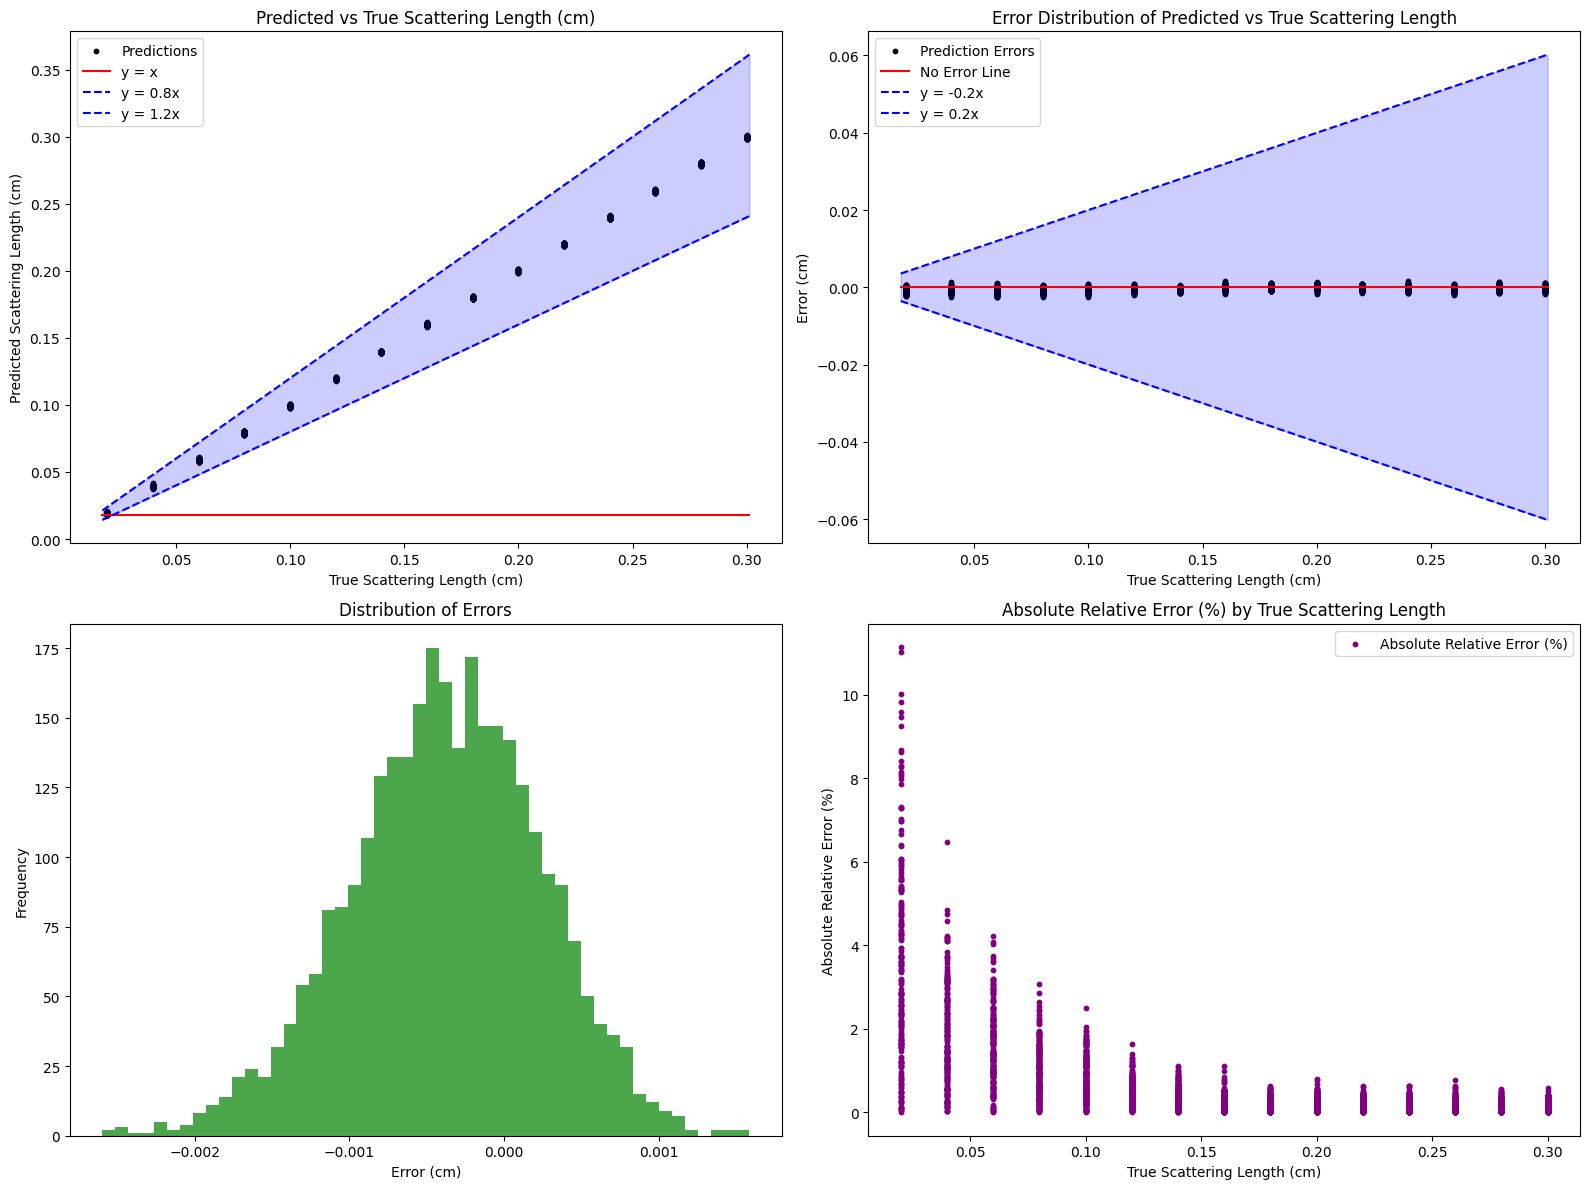

In [1]:
import os
import random
import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

# ─────────────────────────────────────────────────────────────────────────────
# 1) Dataset 정의 및 HDF5 로드
# ─────────────────────────────────────────────────────────────────────────────
class NoisyImageDataset(Dataset):
    def __init__(self, images, labels, lbl_min, lbl_max):
        """
        images: (N, H, W) numpy array, raw pixel values
        labels: (N,) numpy array, raw labels
        lbl_min, lbl_max: 레이블 Min–Max 정규화 상수
        """
        self.images = images.astype(np.float32)  # (N, H, W)
        self.labels = labels.astype(np.float32)  # (N,)
        self.lbl_min = lbl_min
        self.lbl_max = lbl_max

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]    # (H, W)
        lbl = self.labels[idx]    # float

        # 1) 이미지 Min–Max 정규화 → [0,1]
        img_norm = img / 4095.0   # raw 픽셀은 0~4095 범위라고 가정

        # 채널 차원 추가 → (1, H, W)
        img_tensor = torch.from_numpy(img_norm).unsqueeze(0).float()

        # 2) 레이블 [-1, 1] 정규화
        lbl_norm = (lbl - self.lbl_min) / (self.lbl_max - self.lbl_min + 1e-8)  # [0,1]
        lbl_scaled = lbl_norm * 2.0 - 1.0                                      # [-1,1]
        lbl_tensor = torch.tensor(lbl_scaled, dtype=torch.float32)

        return img_tensor, lbl_tensor


# HDF5 파일 경로
hdf5_path = '/home/work/CamSim/SimData_Hole/ICRC_Data/beam_80/hr_0.5_1000.h5'

# HDF5 로드 및 raw_images, raw_labels 배열 얻기
with h5py.File(hdf5_path, 'r') as f:
    raw_images = f['images'][:]   # shape = (N, 500, 500)
    raw_labels = f['labels'][:]   # shape = (N,)

# 전체 데이터 개수 확인
num_samples_images = raw_images.shape[0]  # 이미지 샘플 수
num_samples_labels = raw_labels.shape[0]  # 레이블 샘플 수

print(f"Total samples (images): {num_samples_images}")
print(f"Total samples (labels): {num_samples_labels}")

# HDF5 파일 경로
# 레이블 Min/Max 계산 (원본 레이블)
lbl_min = raw_labels.min()
lbl_max = raw_labels.max()

# Dataset 인스턴스 생성 (전체 데이터)
dataset = NoisyImageDataset(raw_images, raw_labels, lbl_min, lbl_max)

# ─────────────────────────────────────────────────────────────────────────────
# 2) Train/Val/Test 분할 (각 레이블마다 100개 → 10/10/80 split)
# ─────────────────────────────────────────────────────────────────────────────

# 레이블 고유값
unique_labels = np.unique(raw_labels)

train_indices = []
val_indices = []
test_indices = []

# 각 레이블마다 인덱스 추출 후 shuffle → split (Train 60%, Val 20%, Test 20%)
for lbl in unique_labels:
    # 해당 레이블의 모든 인덱스
    indices = np.where(raw_labels == lbl)[0].tolist()
    random.shuffle(indices)
    
    n_total = len(indices)
    n_test  = int(n_total * 0.20)
    n_val   = int(n_total * 0.20)
    n_train = n_total - n_test - n_val
    
    # 인덱스를 비율별로 분할
    test_indices.extend(indices[:n_test])
    val_indices.extend(indices[n_test:n_test + n_val])
    train_indices.extend(indices[n_test + n_val:n_test + n_val + n_train])

# Subset 및 DataLoader 생성
batch_size = 32

train_loader = DataLoader(Subset(dataset, train_indices),
                          batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(Subset(dataset, val_indices),
                        batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(Subset(dataset, test_indices),
                         batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Train samples: {len(train_indices)}, Val samples: {len(val_indices)}, Test samples: {len(test_indices)}")


# ─────────────────────────────────────────────────────────────────────────────
# 3) ResNet4 모델 정의
# ─────────────────────────────────────────────────────────────────────────────
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes * BasicBlock.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes * BasicBlock.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * BasicBlock.expansion)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet4(nn.Module):
    def __init__(self, block=BasicBlock, num_blocks=[1,1,1,1], num_classes=1):
        super().__init__()
        self.in_planes = 64

        # 초기 Convolution
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # 4개 레이어
        self.layer1 = self._make_layer(block, 64,  num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # 평균 풀링 후 FC
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc      = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        layers = []
        layers.append(block(self.in_planes, planes, stride))
        self.in_planes = planes * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_planes, planes, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        # x: (batch, 1, 500, 500)
        out = F.relu(self.bn1(self.conv1(x)))  # (batch,64,250,250)
        out = self.pool1(out)                  # (batch,64,125,125)

        out = self.layer1(out)  # (batch,64,125,125)
        out = self.layer2(out)  # (batch,128,63,63)
        out = self.layer3(out)  # (batch,256,32,32)
        out = self.layer4(out)  # (batch,512,16,16)

        out = self.avgpool(out)       # (batch,512,1,1)
        out = torch.flatten(out, 1)   # (batch,512)
        out = self.fc(out)            # (batch,1)
        return out


# ─────────────────────────────────────────────────────────────────────────────
# 4) 모델/Optimizer/Scheduler 준비
# ─────────────────────────────────────────────────────────────────────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)
model = ResNet4(block=BasicBlock, num_blocks=[1,1,1,1], num_classes=1).to(device)

criterion = nn.MSELoss()             # 회귀용 손실 함수
optimizer = Adam(model.parameters(), lr=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=2, eta_min=1e-5)


# ─────────────────────────────────────────────────────────────────────────────
# 5) 학습 및 검증 함수 정의
# ─────────────────────────────────────────────────────────────────────────────
def train_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                   num_epochs=100, patience=10):
    best_val_loss = float('inf')
    wait = 0

    for epoch in range(1, num_epochs + 1):
        # Training
        model.train()
        running_train_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)               # (batch,1,500,500)
            labels = labels.to(device)               # (batch,) in [-1,1]
            optimizer.zero_grad()

            outputs = model(images).squeeze(1)       # (batch,)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * images.size(0)

        scheduler.step()

        # Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images).squeeze(1)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)

        train_loss = running_train_loss / len(train_loader.dataset)
        val_loss   = running_val_loss   / len(val_loader.dataset)

        lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | LR: {lr:.6g}")

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    return model


# ─────────────────────────────────────────────────────────────────────────────
# 6) 모델 학습 실행
# ─────────────────────────────────────────────────────────────────────────────
model = train_validate(model, train_loader, val_loader, 
                       criterion, optimizer, scheduler,
                       num_epochs=100, patience=10)


# ─────────────────────────────────────────────────────────────────────────────
# 7) 테스트세트 평가 및 결과 저장
# ─────────────────────────────────────────────────────────────────────────────
model.eval()
true_vals = []
pred_vals = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images).squeeze(1)  # (batch,) in [-1,1]
        # 레이블과 예측값을 원래 스케일로 되돌리기
        # inverse: orig = ((norm_lbl + 1)/2)*(lbl_max - lbl_min) + lbl_min
        labels_orig = ((labels.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min
        preds_orig  = ((outputs.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min

        true_vals.extend(labels_orig.tolist())
        pred_vals.extend(preds_orig.tolist())

true_vals = np.array(true_vals)
pred_vals = np.array(pred_vals)

# 계산: errors, abs_rel_errors
errors = pred_vals - true_vals
abs_rel_errors = np.abs(errors / true_vals) * 100.0


# ─────────────────────────────────────────────────────────────────────────────
# 8) 결과 시각화
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(16, 12))

# (1) Predicted vs True with 80–120% band
ax1 = plt.subplot(2, 2, 1)
ax1.scatter(true_vals, pred_vals, s=10, color='black', label='Predictions')
mn = min(true_vals.min(), pred_vals.min())
mx = max(true_vals.max(), pred_vals.max())
ax1.plot([mn, mx], [mn, mn], color='red', label='y = x')
ax1.plot([mn, mx], [0.8*mn, 0.8*mx], '--', color='blue', label='y = 0.8x')
ax1.plot([mn, mx], [1.2*mn, 1.2*mx], '--', color='blue', label='y = 1.2x')
ax1.fill_between([mn, mx], [0.8*mn, 0.8*mx], [1.2*mn, 1.2*mx], color='blue', alpha=0.2)
ax1.set_title("Predicted vs True Scattering Length (cm)")
ax1.set_xlabel("True Scattering Length (cm)")
ax1.set_ylabel("Predicted Scattering Length (cm)")
ax1.legend()

# (2) Error Distribution vs True with ±20% band
ax2 = plt.subplot(2, 2, 2)
ax2.scatter(true_vals, errors, s=10, color='black', label='Prediction Errors')
ax2.plot([mn, mx], [0, 0], '-', color='red', label='No Error Line')
ax2.plot([mn, mx], [-0.2*mn, -0.2*mx], '--', color='blue', label='y = -0.2x')
ax2.plot([mn, mx], [0.2*mn, 0.2*mx], '--', color='blue', label='y = 0.2x')
ax2.fill_between([mn, mx], [-0.2*mn, -0.2*mx], [0.2*mn, 0.2*mx], color='blue', alpha=0.2)
ax2.set_title("Error Distribution of Predicted vs True Scattering Length")
ax2.set_xlabel("True Scattering Length (cm)")
ax2.set_ylabel("Error (cm)")
ax2.legend()

# (3) Histogram of Errors
ax3 = plt.subplot(2, 2, 3)
ax3.hist(errors, bins=50, color='green', alpha=0.7)
ax3.set_title("Distribution of Errors")
ax3.set_xlabel("Error (cm)")
ax3.set_ylabel("Frequency")

# (4) Absolute Relative Error (%) by True Scattering Length
ax4 = plt.subplot(2, 2, 4)
ax4.scatter(true_vals, abs_rel_errors, s=10, color='purple', label='Absolute Relative Error (%)')
ax4.set_title("Absolute Relative Error (%) by True Scattering Length")
ax4.set_xlabel("True Scattering Length (cm)")
ax4.set_ylabel("Absolute Relative Error (%)")
ax4.legend()

plt.tight_layout()
plt.show()


In [3]:
save_path = '/home/work/CamSim/SimData_Hole/ICRC_Data/beam_80/hr_0.5_resnet4_checkpoint.pth'
torch.save({
    'epoch': 100,                   # 마지막으로 학습된 에폭 번호 (train_validate 함수에서 반환하거나 변수로 관리)
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train_loss': 0.000011,         # 마지막 에폭의 train loss
    'val_loss': 0.000026              # 마지막 에폭의 val loss
}, save_path)

print(f"Model checkpoint saved to: {save_path}")

Model checkpoint saved to: /home/work/CamSim/SimData_Hole/ICRC_Data/beam_80/hr_0.5_resnet4_checkpoint.pth


In [5]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet4(block=BasicBlock, num_blocks=[1,1,1,1], num_classes=1).to(device)
optimizer = Adam(model.parameters(), lr=1e-4)

# 2) 체크포인트 로드
checkpoint = torch.load(save_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# CosineAnnealingLR 대신, ReduceLROnPlateau 스케줄러로 교체
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

start_epoch = checkpoint.get('epoch', 0) + 1
best_val_loss = checkpoint.get('val_loss', float('inf'))
print(f"Loaded checkpoint from epoch {checkpoint.get('epoch', 0)}. Continue from epoch {start_epoch}.")

# 3) 이어서 학습: 추가할 에폭 수 정의
additional_epochs = 50
total_epochs = start_epoch + additional_epochs - 1
patience = 10
wait = 0

for epoch in range(start_epoch, total_epochs + 1):
    # ─── Training ────────────────────────────────────────────────
    model.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * images.size(0)

    # ─── Validation ──────────────────────────────────────────────
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images).squeeze(1)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)

    train_loss = running_train_loss / len(train_loader.dataset)
    val_loss   = running_val_loss   / len(val_loader.dataset)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"[Epoch {epoch}/{total_epochs}] Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | LR: {current_lr:.6g}")

    # ─── ReduceLROnPlateau 업데이트 ───────────────────────────────
    scheduler.step(val_loss)

    # ─── Early Stopping 및 체크포인트 갱신 ─────────────────────────
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }, save_path)
        print(f"  → Improved val loss. Checkpoint updated at epoch {epoch}.")
    else:
        wait += 1
        if wait >= patience:
            print(f"  → Early stopping at epoch {epoch}.")
            break

# ─── 최종 모델 저장 ─────────────────────────────────────────────────
final_save_path = save_path.replace('.pth', '_final.pth')
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss
}, final_save_path)
print(f"Final model saved to: {final_save_path}")


Loaded checkpoint from epoch 105. Continue from epoch 106.


/tmp/ipykernel_845/649952281.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_path, map_location=device)


[Epoch 106/155] Train Loss: 0.000040 | Val Loss: 0.000051 | LR: 0.0001
[Epoch 107/155] Train Loss: 0.000057 | Val Loss: 0.000097 | LR: 0.0001
[Epoch 108/155] Train Loss: 0.000025 | Val Loss: 0.000027 | LR: 0.0001
[Epoch 109/155] Train Loss: 0.000023 | Val Loss: 0.000055 | LR: 0.0001
[Epoch 110/155] Train Loss: 0.000041 | Val Loss: 0.000057 | LR: 0.0001
[Epoch 111/155] Train Loss: 0.000031 | Val Loss: 0.000137 | LR: 0.0001
[Epoch 112/155] Train Loss: 0.000009 | Val Loss: 0.000023 | LR: 5e-05
[Epoch 113/155] Train Loss: 0.000007 | Val Loss: 0.000014 | LR: 5e-05
  → Improved val loss. Checkpoint updated at epoch 113.
[Epoch 114/155] Train Loss: 0.000006 | Val Loss: 0.000021 | LR: 5e-05
[Epoch 115/155] Train Loss: 0.000008 | Val Loss: 0.000023 | LR: 5e-05
[Epoch 116/155] Train Loss: 0.000006 | Val Loss: 0.000079 | LR: 5e-05
[Epoch 117/155] Train Loss: 0.000007 | Val Loss: 0.000011 | LR: 2.5e-05
  → Improved val loss. Checkpoint updated at epoch 117.
[Epoch 118/155] Train Loss: 0.000003 | V

Loaded best model (state_dict) from: /home/work/CamSim/SimData_Hole/ICRC_Data/beam_80/hr_0.5_resnet4_checkpoint_final.pth


/tmp/ipykernel_845/4292083586.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_path, map_location=device)


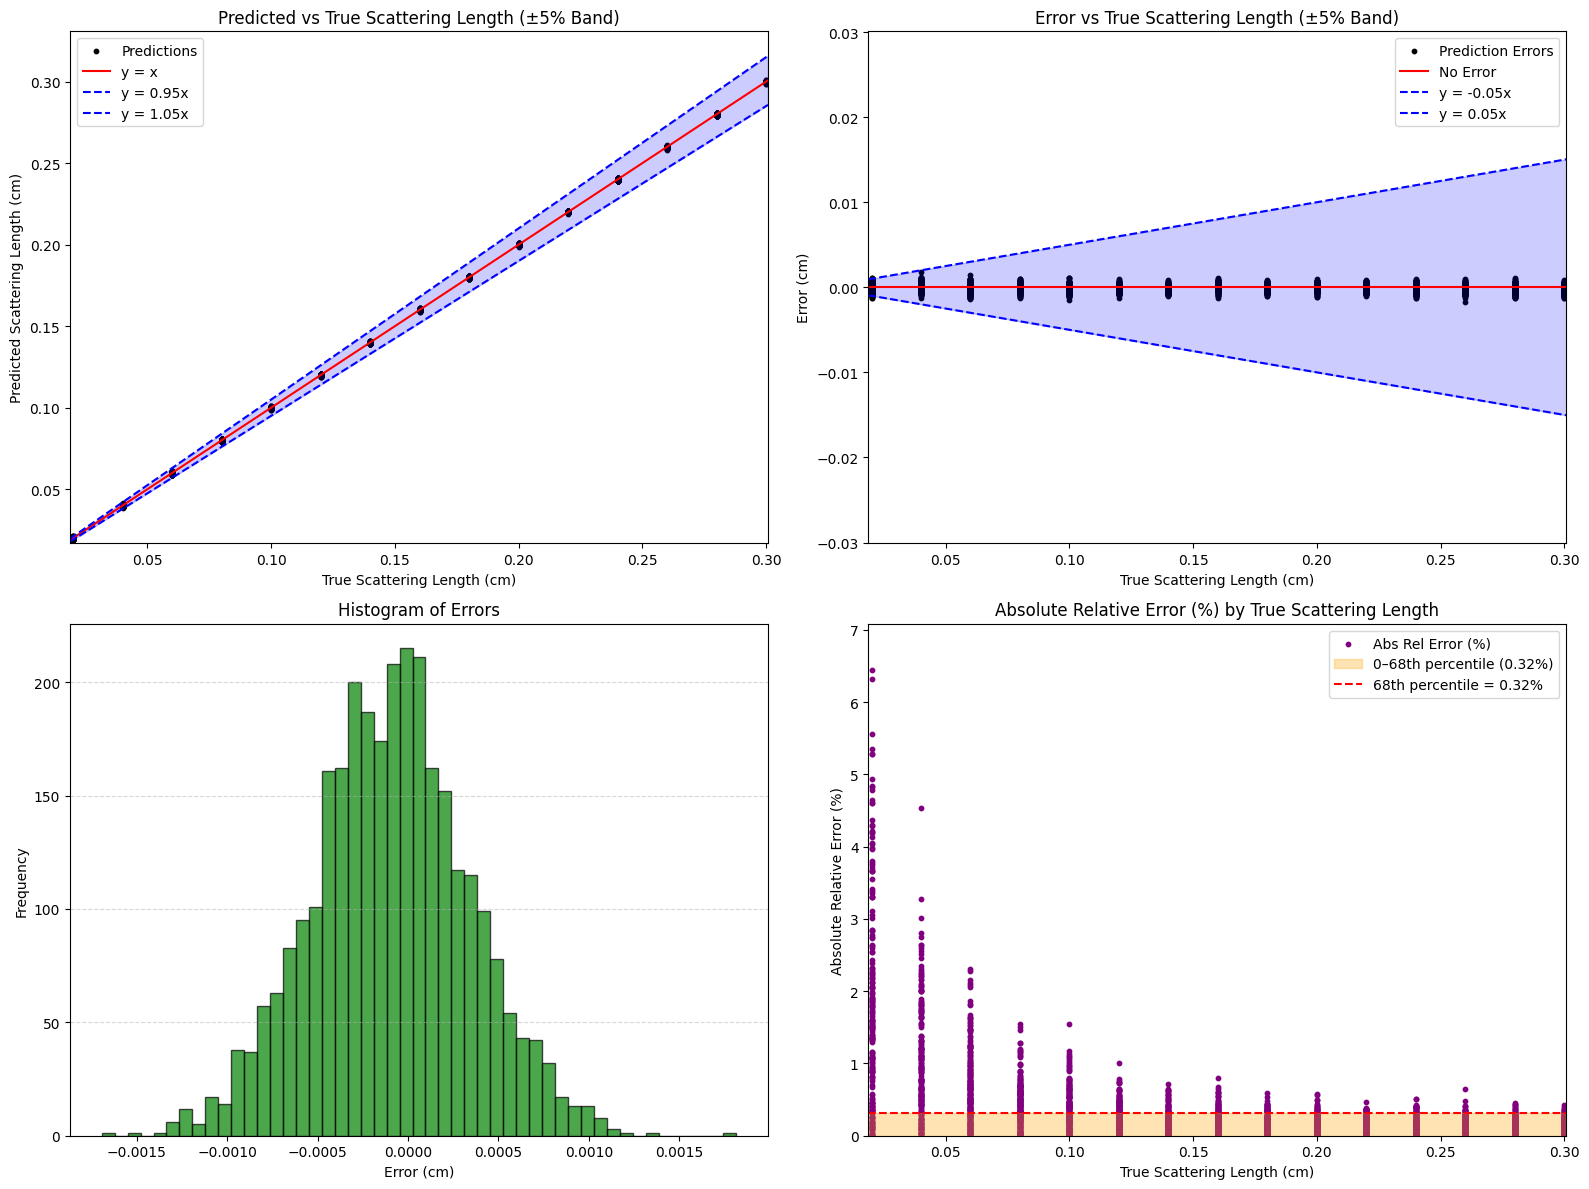

In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────────────────────
# (1) 저장된 Best 모델 로드 (state_dict만 가져와야 합니다)
# ─────────────────────────────────────────────────────────────────────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ① 같은 아키텍처로 모델을 다시 생성
model = ResNet4(block=BasicBlock, num_blocks=[1,1,1,1], num_classes=1).to(device)

# ② 체크포인트 로드
best_path = '/home/work/CamSim/SimData_Hole/ICRC_Data/beam_80/hr_0.5_resnet4_checkpoint_final.pth'
checkpoint = torch.load(best_path, map_location=device)

# checkpoint는 {'epoch': ..., 'model_state_dict': ..., 'optimizer_state_dict': ..., ...} 형태이므로
# 바로 model.load_state_dict(checkpoint)가 아니라 checkpoint['model_state_dict']를 사용해야 합니다.
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()
print(f"Loaded best model (state_dict) from: {best_path}")
# ─────────────────────────────────────────────────────────────────────────────

# ─────────────────────────────────────────────────────────────────────────────
# (2) 테스트 세트에 대해 예측 수행
# ─────────────────────────────────────────────────────────────────────────────
true_vals = []
pred_vals = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images).squeeze(1)  # shape = (batch,)

        # 정규화 되었던 레이블을 원래 스케일로 되돌리기
        labels_orig = ((labels.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min
        preds_orig  = ((outputs.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min

        true_vals.extend(labels_orig.tolist())
        pred_vals.extend(preds_orig.tolist())

true_vals = np.array(true_vals)
pred_vals = np.array(pred_vals)

# errors, absolute relative error (%)
errors = pred_vals - true_vals
abs_rel_errors = np.abs(errors / true_vals) * 100.0
# ─────────────────────────────────────────────────────────────────────────────

# ─────────────────────────────────────────────────────────────────────────────
# (3) 네 가지 그래프 그리기
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(16, 12))

mn = min(true_vals.min(), pred_vals.min())
mx = max(true_vals.max(), pred_vals.max())

# 1) Predicted vs True with ±5% band
ax1 = plt.subplot(2, 2, 1)
ax1.scatter(true_vals, pred_vals, s=10, color='black', label='Predictions')

# y = x (ideal) -> 올바르게 그리기
ax1.plot([mn, mx], [mn, mx], color='red', label='y = x')

# y = 0.95x, y = 1.05x (±5%)
ax1.plot([mn, mx], [0.95*mn, 0.95*mx], '--', color='blue', label='y = 0.95x')
ax1.plot([mn, mx], [1.05*mn, 1.05*mx], '--', color='blue', label='y = 1.05x')

# ±5% 밴드 채우기
ax1.fill_between([mn, mx],
                 [0.95*mn, 0.95*mx],
                 [1.05*mn, 1.05*mx],
                 color='blue', alpha=0.2)

ax1.set_title("Predicted vs True Scattering Length (±5% Band)")
ax1.set_xlabel("True Scattering Length (cm)")
ax1.set_ylabel("Predicted Scattering Length (cm)")
ax1.set_xlim(mn, mx)
ax1.set_ylim(mn * 0.9, mx * 1.1)
ax1.legend()

# 2) Error vs True with ±5% band
ax2 = plt.subplot(2, 2, 2)
ax2.scatter(true_vals, errors, s=10, color='black', label='Prediction Errors')

# y = 0 (no error)
ax2.plot([mn, mx], [0, 0], '-', color='red', label='No Error')

# y = ±0.05 * true (±5% error)
ax2.plot([mn, mx], [-0.05*mn, -0.05*mx], '--', color='blue', label='y = -0.05x')
ax2.plot([mn, mx], [0.05*mn, 0.05*mx], '--', color='blue', label='y = 0.05x')

# ±5% 영역 채우기
ax2.fill_between([mn, mx],
                 [-0.05*mn, -0.05*mx],
                 [0.05*mn, 0.05*mx],
                 color='blue', alpha=0.2)

ax2.set_title("Error vs True Scattering Length (±5% Band)")
ax2.set_xlabel("True Scattering Length (cm)")
ax2.set_ylabel("Error (cm)")
ax2.set_xlim(mn, mx)
ax2.set_ylim(-0.1 * mx, 0.1 * mx)
ax2.legend()

# 3) Histogram of Errors (50 bins)
ax3 = plt.subplot(2, 2, 3)
bins = np.linspace(errors.min(), errors.max(), 50)
ax3.hist(errors, bins=bins, color='green', alpha=0.7, edgecolor='black')
ax3.set_title("Histogram of Errors")
ax3.set_xlabel("Error (cm)")
ax3.set_ylabel("Frequency")
ax3.grid(axis='y', linestyle='--', alpha=0.5)

# 4) Absolute Relative Error (%) by True with 68th percentile
ax4 = plt.subplot(2, 2, 4)
ax4.scatter(true_vals, abs_rel_errors, s=10, color='purple', label='Abs Rel Error (%)')

# 68th percentile 계산
perc68 = np.percentile(abs_rel_errors, 68)

# 0에서 68th percentile까지 영역 채우기
ax4.fill_between([mn, mx], 0, perc68, color='orange', alpha=0.3,
                 label=f'0–68th percentile ({perc68:.2f}%)')

# 68th percentile 선
ax4.hlines(perc68, mn, mx, colors='red', linestyles='--',
           label=f'68th percentile = {perc68:.2f}%')

ax4.set_title("Absolute Relative Error (%) by True Scattering Length")
ax4.set_xlabel("True Scattering Length (cm)")
ax4.set_ylabel("Absolute Relative Error (%)")
ax4.set_xlim(mn, mx)
ax4.set_ylim(0, max(abs_rel_errors) * 1.1)
ax4.legend()

plt.tight_layout()
plt.show()
